<a href="https://colab.research.google.com/github/saleh1312/DeepFake/blob/main/gan_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 30kB/s 
     |████████████████████████████████| 450kB 34.7MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 3.9MB 36.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=1115e4e22cfb80b7b89b86a8827fb9dc6e62b6653757c846b7956c84a15f6c1e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninsta

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras as keras
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from numpy import argmax
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from PIL import Image
from sklearn.utils import shuffle
from tensorflow.keras.layers import LeakyReLU

In [ ]:
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Layer

In [ ]:
nico_x = np.load('/content/drive/MyDrive/da7ee7.npy').astype(np.float32)
scar_x = np.load('/content/drive/MyDrive/scar.npy').astype(np.float32)
nico_x=nico_x/255.0
scar_x=scar_x/255.0
nico_x[nico_x<0]=-1
scar_x[scar_x<0]=-1

In [ ]:
da7=tf.keras.models.load_model('/content/drive/MyDrive/encoder-da7ee7.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(0.2)})
scar=tf.keras.models.load_model('/content/drive/MyDrive/encoder-scar.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(0.2)})

In [ ]:
k=False
for layer in da7.layers:
    if layer.name == "conv2d_4":
        k=True
    layer.trainable = k

In [ ]:
input_imgd=Input(shape=(128, 128, 3))
l=Conv2D(256,(9,9),padding='same')(input_imgd)
l=MaxPool2D()(l)
l=Conv2D(64,(9,9),padding='same')(l)
l=MaxPool2D()(l)
l=Conv2D(16,(9,9),padding='same')(l)
l=MaxPool2D()(l)
l=Flatten()(l)
decodedd = Dense(64,activation='relu')(l)
decodedd = Dense(1,activation='sigmoid')(decodedd)
diso=Model(input_imgd,decodedd)

In [ ]:
optimizer_d = tf.keras.optimizers.Adam(0.001)
optimizer_g = tf.keras.optimizers.Adam(0.001)

In [ ]:
diso.compile(loss='binary_crossentropy',
    optimizer=optimizer_d,
    metrics=['accuracy'])

In [ ]:
z = Input(shape=(128,128,3))
img = da7(z)
diso.trainable = False 
valid = diso(img)
combined = Model(z, valid)


In [ ]:
combined.compile(loss='binary_crossentropy', optimizer=optimizer_g)

In [ ]:
def train_step(i,batch_size,g,d):
  x=np.zeros((batch_size*2,nico_x.shape[1],nico_x.shape[2],nico_x.shape[3]),np.float32) # (64, 128,128,3)
  y=np.zeros((batch_size*2,1),np.float32)

  idx=np.arange(i,i+batch_size)
  real_da7 = nico_x[idx] # real da7e7

  real_scar = scar_x[idx]
  fake_da7=da7.predict(real_scar) # fake da7e7

  real_y=np.ones((batch_size, 1))
  fake_y=np.zeros((batch_size, 1))

  idx_real=np.arange(0,batch_size)
  idx_fake=np.arange(batch_size,batch_size*2)

  #stack real with fake
  x[idx_real]=real_da7
  x[idx_fake]=fake_da7
  y[idx_real]=real_y
  y[idx_fake]=fake_y
      

  x,y=shuffle(x,y)

  if d:

    diso.train_on_batch(x, y)
  if g:

    combined.train_on_batch(real_scar, real_y)



In [ ]:
p=0
def train(epochs=10, batch_size=32,train_g=True,train_d=True): 
  global p
  for epoch in range(epochs):

    for i in range(0,nico_x.shape[0],batch_size):
      if (i+batch_size) <nico_x.shape[0]:
        train_step(i,batch_size,train_g,train_d)
      else:
        train_step(i,(nico_x.shape[0] -i),train_g,train_d)
        break

      
    if epoch %5 ==0:
      print(epoch)

  

In [ ]:
train(epochs=100, batch_size=16,train_g= True,train_d= True)

0
5
10
15
20
25
30
35
40
45
50


showing results


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


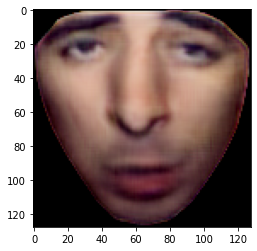

In [ ]:
img=nico_x[0]
t=np.reshape(img,(1,128,128,3)).astype(np.float32)
o=da7.predict(t)
o=((((np.reshape(o,(128,128,3)).astype(np.float32)))))
o=cv2.cvtColor(o,cv2.COLOR_BGR2RGB)
plt.imshow(o)